In [1]:
from src.jaywalk_gym.jaywalk_env import EnvParams, JaywalkEnv


easy_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
)
easy_env = JaywalkEnv(easy_params)

In [2]:
medium_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
    num_lane_groups=3,
    max_vehicles=30,
    p_vehicle_spawn=0.8,
    p_vehicle_stop=0.5,
)
medium_env = JaywalkEnv(medium_params)

In [3]:
hard_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
    num_lane_groups=4,
    max_vehicles=50,
    p_vehicle_spawn=0.9,
    p_vehicle_stop=0.3,
)
hard_env = JaywalkEnv(hard_params)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_importance_heatmap(weights, rows, cols, title="Importance Heatmap of World Grid"):
    """
    Plot an importance heatmap for a given weight matrix.

    Parameters:
        weights (torch.Tensor): The weight tensor from which to calculate importance.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        title (str): Title for the plot.

    Returns:
        None
    """
    # Aggregate importance across neurons (absolute sum of weights for each input)
    importance = np.abs(weights.numpy()).sum(axis=0)[3:]  # Adjusting slice as per example

    # Reshape the importance back into the grid
    importance_grid = importance.reshape(rows, cols)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.imshow(importance_grid, cmap="viridis", aspect="auto")
    plt.colorbar(label="Weight")
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    # Optionally annotate each cell with the importance value
    for i in range(rows):
        for j in range(cols):
            plt.text(
                j,
                i,
                f"{importance_grid[i, j]:.2f}",
                ha="center",
                va="center",
                color="black"
                if importance_grid[i, j] > importance_grid.max() / 2
                else "white",
            )

    plt.show()

In [5]:
import torch
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt

def plot_weight_attribution(model, state_input, rows, cols, title="Attribution Heatmap"):
    """
    Computes and plots the weight attribution for a given state input using Captum.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        state_input (torch.Tensor): The state input tensor.
        rows (int): Number of rows in the input grid.
        cols (int): Number of columns in the input grid.
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Define the attribution method
    ig = IntegratedGradients(model)
    
    # Compute attributions
    state_input.requires_grad = True
    attributions, _ = ig.attribute(state_input, target=0, return_convergence_delta=True)
    
    # Convert attributions to numpy for visualization
    attributions = attributions.detach().numpy().squeeze()[3:]
    
    # Reshape the attributions to grid format
    attribution_grid = attributions.reshape(rows, cols)
    
    # Plot the attributions as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(attribution_grid, cmap="viridis", aspect="auto")
    plt.colorbar(label="Attribution")
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    
    # Optionally annotate each cell with the attribution value
    for i in range(rows):
        for j in range(cols):
            plt.text(
                j,
                i,
                f"{attribution_grid[i, j]:.2f}",
                ha="center",
                va="center",
                color="black" if attribution_grid[i, j] > attribution_grid.max() / 2 else "white",
            )
    
    plt.show()

/Users/karenzhang/Documents/Northeastern/Fall24/RL/FinalProject/jaywalker-rl/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/karenzhang/Documents/Northeastern/Fall24/RL/FinalProject/jaywalker-rl/src/agents/ppo/ppo_agent.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor_checkpoint 

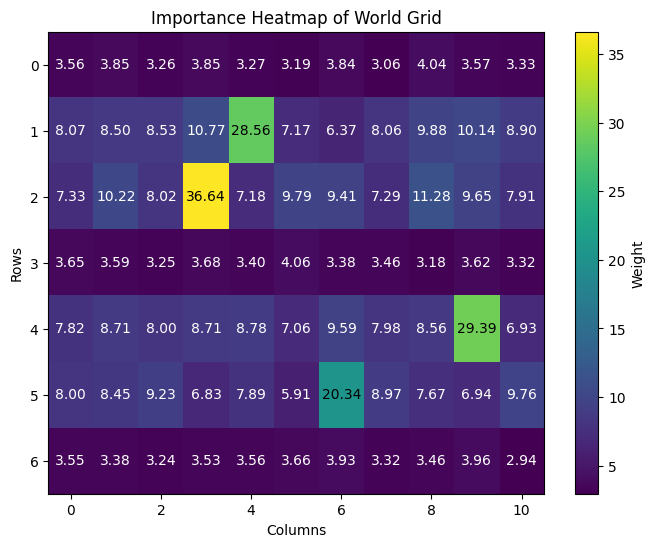

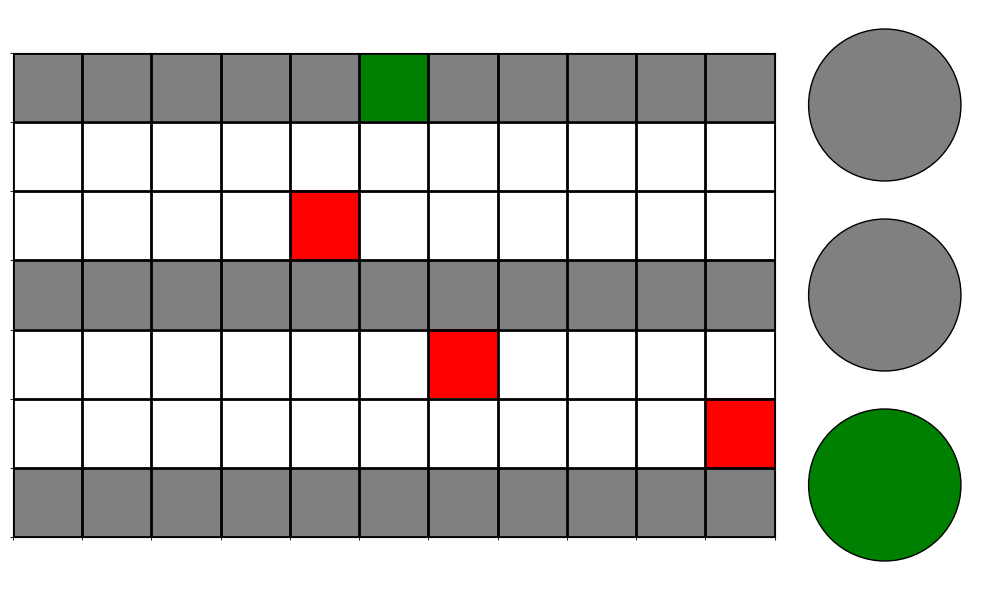

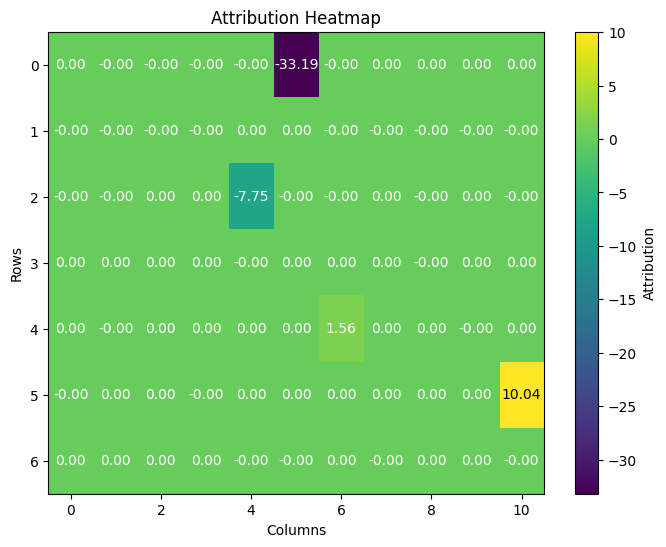

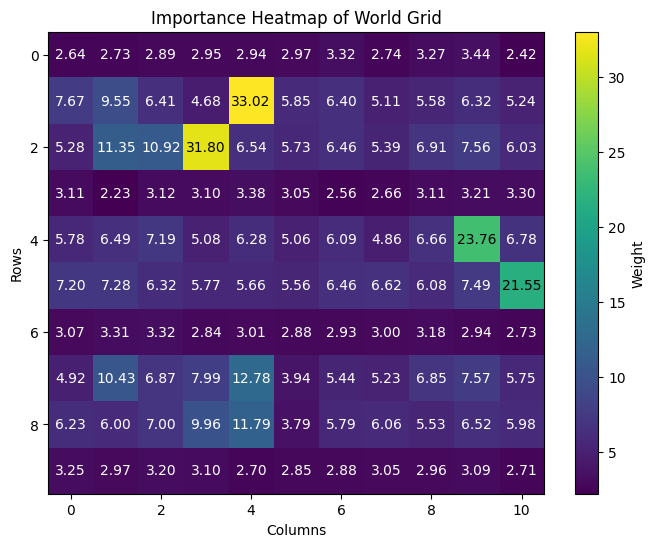

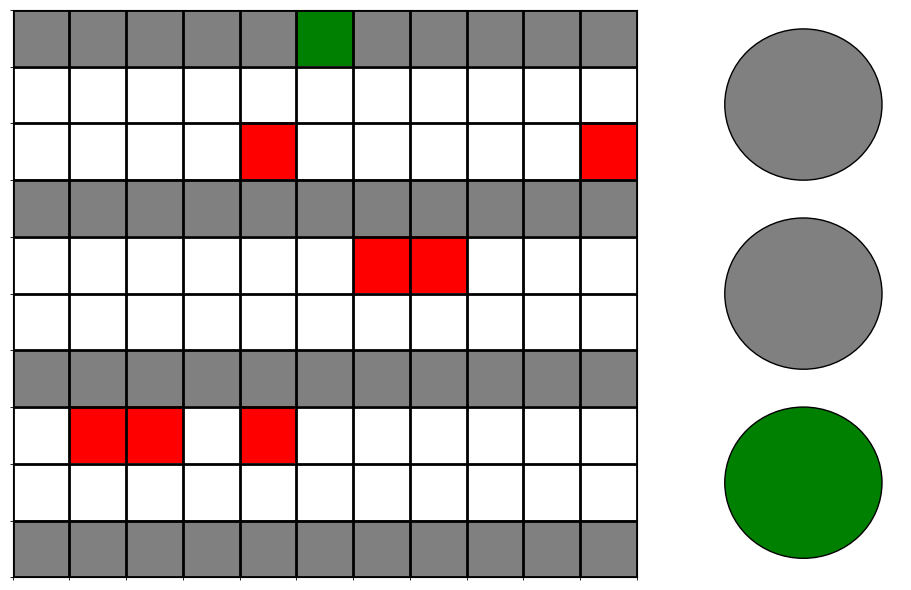

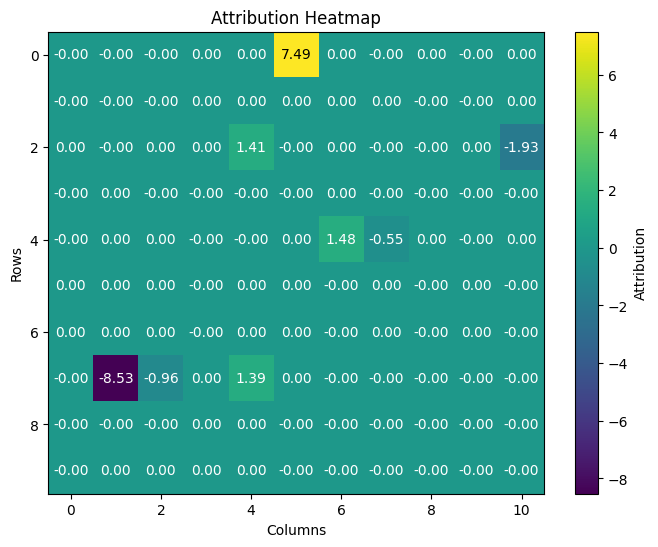

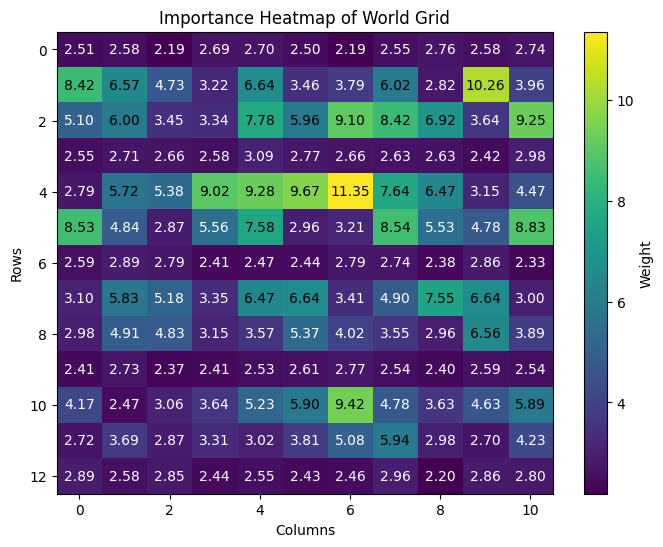

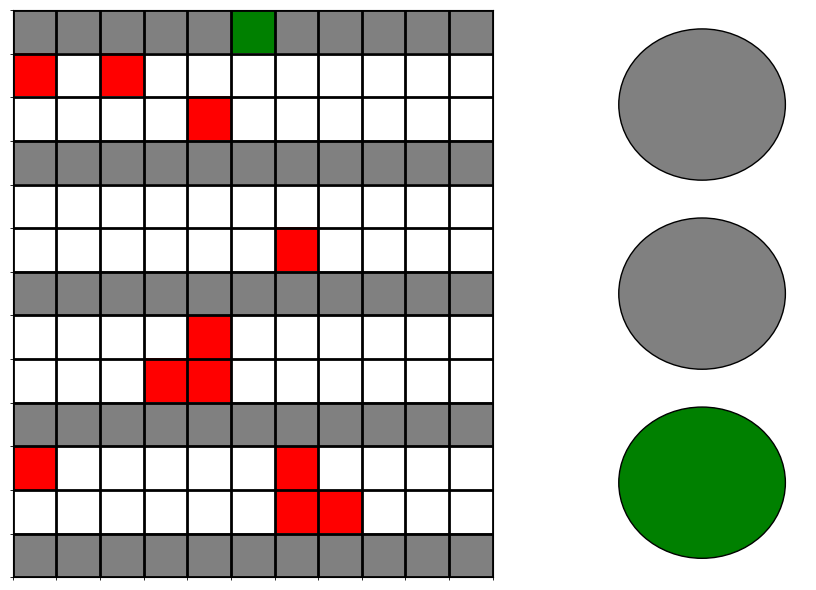

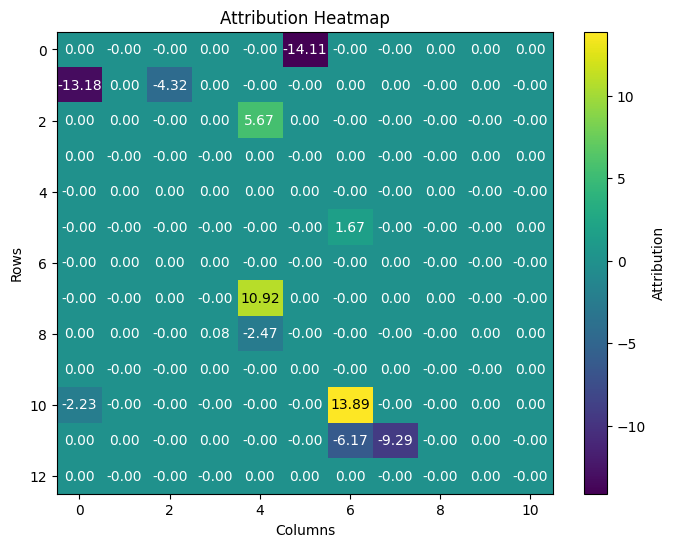

In [6]:
from src.agents.ppo.ppo_agent import PPOAgent

for env_type, env in zip(["easy", "medium", "hard"], [easy_env, medium_env, hard_env]):
    train_parameters = {
            "state_dim": env.grid_shape[0] * env.grid_shape[1] + 3,
            "action_dim": 3,
            "action_space": [0, 1, 2],
            "num_layers": 3,
            "hidden_dim": 64,
            "gamma": 0.99,
            "total_training_time_step": 1000_000,
            "batch_size": 64,
            "learning_rate": 3e-5,
            "device": "cpu",
            "clip": 0.2,
            "epochs_per_iteration": 64,
            "timeout": 200,
        }

    agent = PPOAgent(
        env,
        train_parameters
    )
    agent.load(f"./checkpoints/final_ppo_fixed/{env_type}")

    # Access and print the weights of the first fully connected layer
    for name, param in agent.actor.named_parameters():
        if "network.0.weight" in name:
            weights = param.data
            break

    plot_importance_heatmap(weights, env.grid_shape[0], env.grid_shape[1])

    state, _ = env.reset()
    state_tensor = torch.tensor(agent.transform_state(state)).float().view(1, -1)  # Replace 77 with the actual state size
    env.render(mode="human")
    plot_weight_attribution(agent.actor, state_tensor, rows=env.grid_shape[0], cols=env.grid_shape[1])


torch.Size([1, 146])


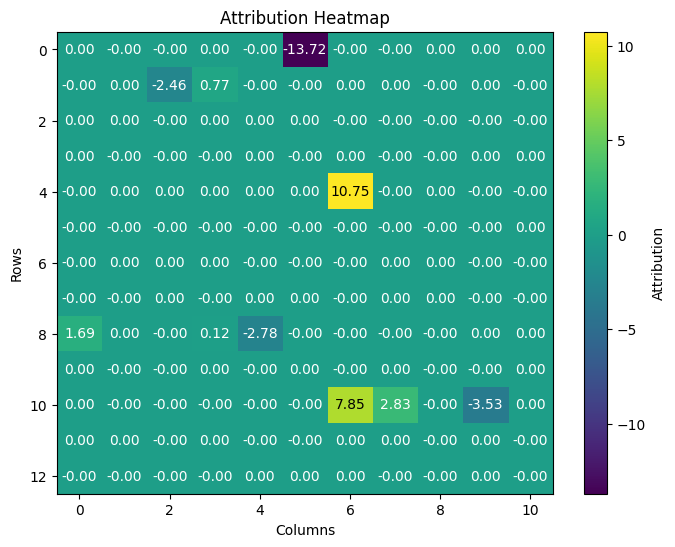

In [7]:


# Example Usage

state, _ = env.reset()
# Assuming `agent.actor` is your model and `state_tensor` is your input
state_tensor = torch.tensor(agent.transform_state(state)).float().view(1, -1)  # Replace 77 with the actual state size
print(state_tensor.shape)
plot_weight_attribution(agent.actor, state_tensor, rows=hard_env.grid_shape[0], cols=hard_env.grid_shape[1])


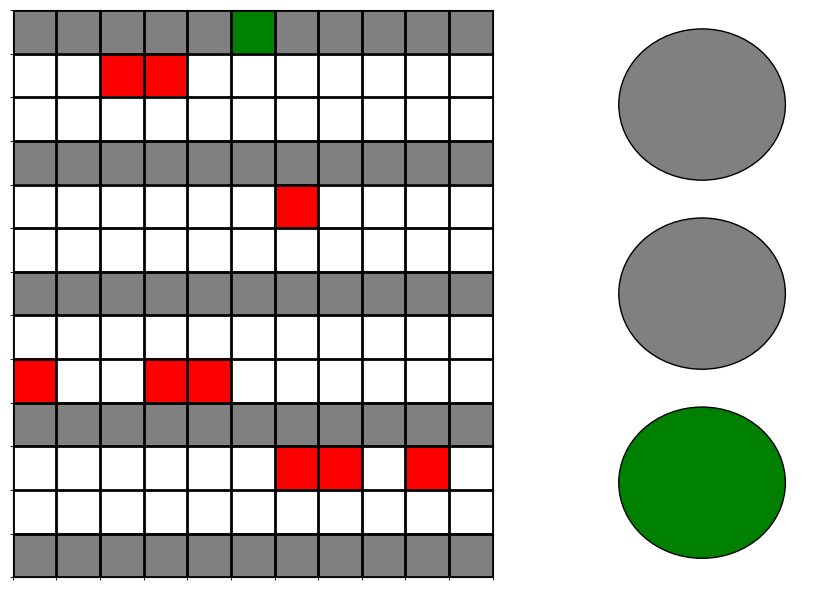

In [8]:
env.render(mode="human")